## import modules

In [ ]:
#!pip install torch==2.2
#!pip install torchvision==0.17
#!pip install matplotlib==3.5.2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

## define model architecture

In [3]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.cn1 = nn.Conv2d(1, 16, 3, 1)
        self.cn2 = nn.Conv2d(16, 32, 3, 1)
        self.dp1 = nn.Dropout2d(0.10)
        self.dp2 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(4608, 64) # 4608 is basically 12 X 12 X 32
        self.fc2 = nn.Linear(64, 10)
 
    def forward(self, x):
        x = self.cn1(x)
        x = F.relu(x)
        x = self.cn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dp1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp2(x)
        x = self.fc2(x)
        op = F.log_softmax(x, dim=1)
        return op

## define training and inference routines

In [4]:
def train(model, device, train_dataloader, optim, epoch):
    model.train()
    for b_i, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        optim.zero_grad()
        pred_prob = model(X)
        loss = F.nll_loss(pred_prob, y) # nll is the negative likelihood loss
        loss.backward()
        optim.step()
        if b_i % 10 == 0:
            print('epoch: {} [{}/{} ({:.0f}%)]\t training loss: {:.6f}'.format(
                epoch, b_i * len(X), len(train_dataloader.dataset),
                100. * b_i / len(train_dataloader), loss.item()))


In [5]:
def test(model, device, test_dataloader):
    model.eval()
    loss = 0
    success = 0
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            pred_prob = model(X)
            loss += F.nll_loss(pred_prob, y, reduction='sum').item()  # loss summed across the batch
            pred = pred_prob.argmax(dim=1, keepdim=True)  # us argmax to get the most likely prediction
            success += pred.eq(y.view_as(pred)).sum().item()

    loss /= len(test_dataloader.dataset)

    print('\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {}/{} ({:.0f}%)\n'.format(
        loss, success, len(test_dataloader.dataset),
        100. * success / len(test_dataloader.dataset)))


## create data loaders

In [6]:
# The mean and standard deviation values are calculated as the mean of all pixel values of all images in the training dataset
train_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1302,), (0.3069,))])), # train_X.mean()/256. and train_X.std()/256.
    batch_size=32, shuffle=True)

test_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1302,), (0.3069,)) 
                   ])),
    batch_size=500, shuffle=False)

## define optimizer and run training epochs

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

In [29]:
device = torch.device('cpu')

In [30]:
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ConvNet()
optimizer = optim.Adadelta(model.parameters(), lr=0.5)

## model training

In [31]:
model = model.to(device)
for epoch in range(1, 3):
    #train(model, device, train_dataloader, optimizer, epoch)
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)

c:\Users\leqian\anaconda3\envs\py312\Lib\site-packages\torch\nn\functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [0/60000 (0%)]	 training loss: 2.302056
epoch: 1 [320/60000 (1%)]	 training loss: 1.851937
epoch: 1 [640/60000 (1%)]	 training loss: 1.082965
epoch: 1 [960/60000 (2%)]	 training loss: 0.895059
epoch: 1 [1280/60000 (2%)]	 training loss: 0.727018
epoch: 1 [1600/60000 (3%)]	 training loss: 0.409475
epoch: 1 [1920/60000 (3%)]	 training loss: 0.414661
epoch: 1 [2240/60000 (4%)]	 training loss: 0.650797
epoch: 1 [2560/60000 (4%)]	 training loss: 0.412143
epoch: 1 [2880/60000 (5%)]	 training loss: 0.351428
epoch: 1 [3200/60000 (5%)]	 training loss: 0.527398
epoch: 1 [3520/60000 (6%)]	 training loss: 0.315825
epoch: 1 [3840/60000 (6%)]	 training loss: 0.425685
epoch: 1 [4160/60000 (7%)]	 training loss: 0.360831
epoch: 1 [4480/60000 (7%)]	 training loss: 0.303605
epoch: 1 [4800/60000 (8%)]	 training loss: 0.598366
epoch: 1 [5120/60000 (9%)]	 training loss: 0.338775
epoch: 1 [5440/60000 (9%)]	 training loss: 0.474756
epoch: 1 [5760/60000 (10%)]	 training loss: 0.133264
epoch: 1 [6080/60

## run inference on trained model

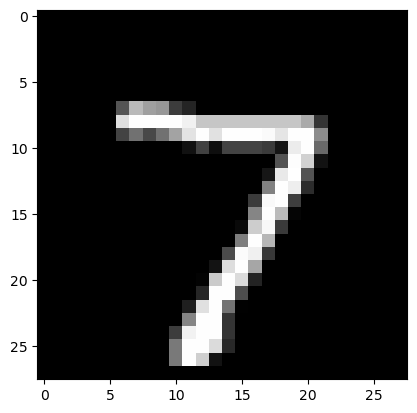

In [32]:
test_samples = enumerate(test_dataloader)
b_i, (sample_data, sample_targets) = next(test_samples)

plt.imshow(sample_data[0][0], cmap='gray', interpolation='none')
plt.show()

In [33]:
print(f"Model prediction is : {model(sample_data).data.max(1)[1][0]}")
print(f"Ground truth is : {sample_targets[0]}")

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor